In [ ]:
import warnings, os, datetime, zipfile, tqdm, gdown, glob, random, shutil, pytz
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [10]:
timezone = pytz.timezone('Europe/Paris')
now = datetime.datetime.now(timezone).strftime('%Y.%m.%d-%H.%M.%S')

project_path = os.getcwd()

is_docker = os.environ.get('IS_DOCKER', False)

if is_docker:
    print("Docker usage detected")
    project_path = f"{project_path}/livrable_2"
else:
    print("Normal usage detected")

paths = {
    "data_path": f"{project_path}/data",
    "train_data_path": f"{project_path}/data/train",
    # "validation_data_path": f"{project_path}/data/validation",
    # "unsorted_validation_data_path": f"{project_path}/data/validation/unsorted",
    # "sorted_validation_data_path": f"{project_path}/data/validation/sorted",
    # "model_path": f"{project_path}/models",
    # "checkpoint_path": f"{project_path}/weights/model_early",
    # "log_path": f"{project_path}/logs/fit/{now}_model"
}

paths_to_delete = [
    # "unsorted_validation_data_path",
    # "sorted_validation_data_path"
]

for key, path in paths.items():
    if key in paths_to_delete and os.path.exists(path):
        print(f"Deleting {path}")
        shutil.rmtree(path)
    os.makedirs(path, exist_ok=True)

image_h = 224
image_w = 224
batch_s = 24
encoding_dim = int(image_h * image_w * 3 * 0.1)

Normal usage detected


In [11]:
def download_dataset(force=False):
    
    dataset_path = f"{paths['train_data_path']}/dataset_livrable_2.zip"

    if os.path.exists(dataset_path) and force == False:
        print("Dataset already downloded")
    else:
        print("Downloading dataset")
        url = 'https://drive.google.com/uc?export=download&id=1WdcW_OqvRyuLiGx0FiZR0KmrqB9VYsLw'
        gdown.download(url, dataset_path, quiet=False)
    
    if len(os.listdir(paths['train_data_path'])) == 6 and force == False:
        print("Dataset already exported")
    else:
        print("Exporting dataset")
        with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
            files = zip_ref.infolist()
            with tqdm.tqdm(total=len(files), desc="Décompression", unit="fichier") as pbar:
                    for file in files:
                        zip_ref.extract(file, paths['train_data_path'])
                        pbar.update(1)
            zip_ref.extractall(paths['train_data_path'])
            print(f"Dataset downloaded {paths['train_data_path']}")
        
download_dataset()

Dataset already downloded
Exporting dataset


Décompression: 100%|██████████| 149/149 [00:00<00:00, 788.41fichier/s]


Dataset downloaded C:\Users\lefra\Documents\Projets\ProjetDeepLearning\livrable_2/data/train


In [12]:
def check_images_in_dataset(dataset_path):
    img_paths = glob.glob(os.path.join(dataset_path, '*/*.*'))

    for img_path in tqdm.tqdm(img_paths, desc="Checking images"):
        try:
            img_bytes = tf.io.read_file(img_path)
            tf.io.decode_image(img_bytes)

        except tf.errors.InvalidArgumentError as e:
            print(f"Found bad file: {img_path}. Removing it.")
            os.remove(img_path)

check_images_in_dataset(paths['train_data_path'])

Checking images: 100%|██████████| 148/148 [00:01<00:00, 99.80it/s] 


In [13]:
train_set, test_set = tf.keras.preprocessing.image_dataset_from_directory(
    paths['train_data_path'],
    validation_split=0.2,
    subset="both",
    seed=42,
    image_size=(image_h, image_w),
    batch_size=batch_s,
    labels="inferred",
    label_mode="int"
)

Found 148 files belonging to 1 classes.
Using 119 files for training.
Using 29 files for validation.


In [14]:
def preprocess_image(image, label):
    image = tf.image.resize_with_pad(image, image_h, image_w)
    return image, label

train_set = train_set.map(preprocess_image)
test_set = test_set.map(preprocess_image)

Image shape:  (24, 224, 224, 3)
Labels shape:  (24,)


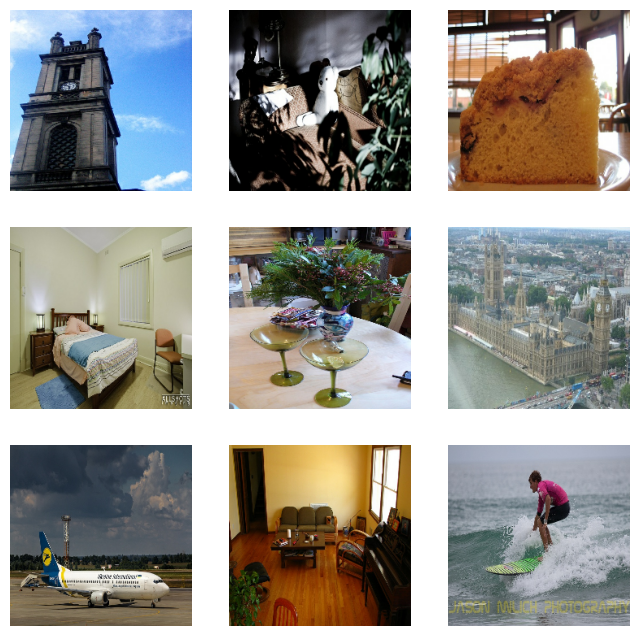

In [15]:
def print_img(dataset, num_images=9):
    plt.figure(figsize=(8, 8))
    for images, labels in dataset.take(1):
        for i in range(num_images):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            # plt.title(f"Label: {class_names[labels[i]]}")
            plt.axis("off")
    plt.show()

images, labels = iter(train_set).next()
print("Image shape: ", images.shape)
print("Labels shape: ", labels.shape)
print_img(train_set, 9)

In [16]:
AUTOTUNE = tf.data.AUTOTUNE
train_set = train_set.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_set = test_set.cache().prefetch(buffer_size=AUTOTUNE)

In [17]:
def create_autoencodeur(input_shape=(image_h, image_w, 3)):
    input_img = tf.keras.layers.Input(shape=input_shape)

    # Encoder
    x = tf.keras.layers.Flatten()(input_img)
    x = tf.keras.layers.Dense(encoding_dim, activation='relu')(x)
    
    # Decoder
    x = tf.keras.layers.Dense(np.prod(input_shape), activation='sigmoid')(x)
    decoded = tf.keras.layers.Reshape(input_shape)(x)
    
    # Modèle autoencodeur
    autoencoder = tf.keras.models.Model(input_img, decoded)

    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

    autoencoder.summary()

    return autoencoder

autoencoder = create_autoencodeur()

KeyboardInterrupt: 